In [1]:
from VAE_trainer import VAETrainer
from DAE_trainer import DAETrainer
from vae import VAE
from dae import DAE
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from sklearn.model_selection import KFold
import torch
from torch.optim import lr_scheduler
import gc
import random


fold_num = 5
random.seed(519)
np.random.seed(519)
kf = KFold(n_splits=fold_num, shuffle=True, random_state=519)
is_transfer_learning = False
gc.enable()

# Generate train data for DAE

In [ ]:
def is_real(angle):
    return len(str(angle).split('.')[1]) <= 4

In [ ]:
train_df = pd.read_json('Data/polar_split_no_denoise_processed_train.json')
train_df.drop(['inc_angle', 'is_iceberg'], axis=1, inplace=True)
print(train_df.shape)

In [ ]:
test_df = pd.read_json('Data/test.json', dtype={'inc_angle': str})
pseudo_mask = test_df.inc_angle.apply(is_real)
print(pseudo_mask.value_counts())
del test_df
gc.collect()

In [ ]:
test_df = pd.read_json('Data/polar_split_no_denoise_processed_test.json')
test_df.sort_index(inplace=True)
test_df = test_df[pseudo_mask]
test_df.drop(['inc_angle', 'is_iceberg'], axis=1, inplace=True)
print(test_df.shape)

In [ ]:
train_df = pd.concat([train_df, test_df])
train_df.reset_index(drop=True, inplace=True)
del test_df
gc.collect()

train_df['band'] = train_df['band_mixed']

print(train_df.shape)

In [ ]:
train_df.drop(['band_mixed'], axis=1, inplace=True)

In [ ]:
print(train_df.columns)

In [ ]:
train_df.reset_index(drop=True, inplace=True)

In [ ]:
train_df.to_json('Data/dae_train.json')

# Train DAE

In [3]:
train_df = pd.read_json('Data/dae_train.json')
train_df.sort_index(inplace=True)
print(train_df.shape)

(5029, 1)


In [4]:
model = DAE() #paperResNet18() #lessFilterResNet50()
model_name = 'Trained_model/dae.db'

data_augmentation_args = {
    'mirror': False, # not useful here
    'rotate': True,
    'scale': True,
    'translation': True,
    'crop': False,
    #'color jitter' : True,
}

optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=0.0001)

tr = DAETrainer(
            model,
        optimizer,
        epochs=75, 
        milestones=[25, 50],
        gamma=0.1,
        batch_size=128, 
        use_cuda=True, 
        gpu_idx=0,
        best_model_name=model_name,
        verbose=0)

tr.train(train_df, valid_df=None, is_transfer_learning=is_transfer_learning, 
         data_augmentation_args=data_augmentation_args, do_sa=False, t_start=0.005, start_epoch=1300)

tr.save(model_name)

gpu: 0  available: True
epoch= 1: Train set: BCE loss: 0.672506
epoch= 2: Train set: BCE loss: 0.639551
epoch= 3: Train set: BCE loss: 0.624620
epoch= 4: Train set: BCE loss: 0.616486
epoch= 5: Train set: BCE loss: 0.610870
epoch= 6: Train set: BCE loss: 0.607102
epoch= 7: Train set: BCE loss: 0.604286
epoch= 8: Train set: BCE loss: 0.602616
epoch= 9: Train set: BCE loss: 0.601013
epoch= 10: Train set: BCE loss: 0.599840
epoch= 11: Train set: BCE loss: 0.599097
epoch= 12: Train set: BCE loss: 0.598540
epoch= 13: Train set: BCE loss: 0.597907
epoch= 14: Train set: BCE loss: 0.597700
epoch= 15: Train set: BCE loss: 0.597587
epoch= 16: Train set: BCE loss: 0.597343
epoch= 17: Train set: BCE loss: 0.597076
epoch= 18: Train set: BCE loss: 0.597168
epoch= 19: Train set: BCE loss: 0.597141
epoch= 20: Train set: BCE loss: 0.596875
epoch= 21: Train set: BCE loss: 0.598099
epoch= 22: Train set: BCE loss: 0.597481
epoch= 23: Train set: BCE loss: 0.597238
epoch= 24: Train set: BCE loss: 0.597115
e

Train images


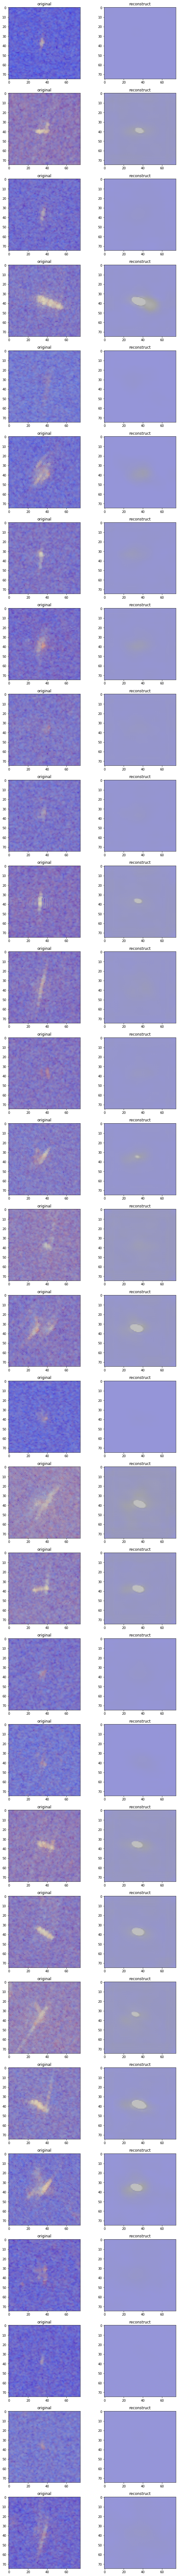

In [5]:
print('Train images')
imgs = tr.test(train_df)
# plot some train images
show_num = 30
fig = plt.figure(1,figsize=(2*5,show_num*5))
for n in range(show_num):
    '''
    if train_df.loc[n, 'is_iceberg'] == True:
        name = 'Iceberg'
    else:
        name = 'Ship'
    '''
    ax = fig.add_subplot(show_num,2,2*n+1)
    #print(np.array(train_df.loc[n,'band']).shape)
    origin_img = np.array(train_df.loc[n,'band']).reshape((75,75,4))
    origin_img *= 255.0
    origin_img = origin_img.astype(np.uint8)
    ax.imshow(origin_img)#[14:62, 14:62]
    ax.set_title('original')

    ax = fig.add_subplot(show_num,2,2*n+2)
    #print(np.array(imgs[n]).shape)
    ax.imshow(imgs[n].reshape((75,75,4)))
    ax.set_title('reconstruct')

In [ ]:
del optimizer, tr, model

> Cross validation

In [ ]:
counter  = 1
for train_index, valid_index in kf.split(train_df):
  
    model = DAE() #paperResNet18() #lessFilterResNet50()
    model_name = 'Trained_model/' + 'dae_' + str(counter) + '.db'
    
    train = train_df.loc[train_index].reset_index(drop=True)
    valid = train_df.loc[valid_index].reset_index(drop=True)
    
    data_augmentation_args = {
        'mirror': False, # not useful here
        'rotate': True,
        'scale': True,
        'translation': True,
        'crop': False,
        #'color jitter' : True,
    }
    
    optimizer = torch.optim.Adam(model.parameters(), lr=0.00001, weight_decay=0.001)

    tr = DAETrainer(
            model,
            optimizer,
            epochs=10, 
            milestones=[25, 50],
            gamma=0.1,
            batch_size=64, 
            use_cuda=True, 
            gpu_idx=0,
            best_model_name=model_name,
            verbose=0)

    tr.train(train, valid_df=valid, is_transfer_learning=is_transfer_learning, 
             data_augmentation_args=data_augmentation_args, do_sa=False, t_start=0.005, start_epoch=1300)
    
    tr.load_checkpoint()
    
    print('Train images')
    imgs = tr.test(train)
    # plot some train images
    show_num = 15
    fig = plt.figure(1,figsize=(2*5,show_num*5))
    for n in range(show_num):
        if train.loc[n, 'is_iceberg'] == True:
            name = 'Iceberg'
        else:
            name = 'Ship'
        ax = fig.add_subplot(show_num,2,2*n+1)
        ax.imshow(np.array(train.loc[n,'band']))#[14:62, 14:62]
        ax.set_title('original ({})'.format(name))

        ax = fig.add_subplot(show_num,2,2*n+2)
        ax.imshow(np.array(imgs[n]))
        ax.set_title('reconstruct')
    
    print('Test images')
    imgs = tr.test(valid)
    # plot some test images
    show_num = 15
    fig = plt.figure(2,figsize=(2*5,show_num*5))
    for n in range(show_num):
        if valid.loc[n, 'is_iceberg'] == True:
            name = 'Iceberg'
        else:
            name = 'Ship'
        ax = fig.add_subplot(show_num,2,2*n+1)
        ax.imshow(np.array(valid.loc[n,'band']))#[14:62, 14:62]
        ax.set_title('original ({})'.format(name))

        ax = fig.add_subplot(show_num,2,2*n+2)
        ax.imshow(np.array(imgs[n]))
        ax.set_title('reconstruct')
    plt.show()

    
    del optimizer, tr, model
    gc.collect()    
    counter += 1

# Genrate final data

In [ ]:
train = pd.read_json('Data/train.json')
test = pd.read_json('Data/test.json')
all_df = pd.concat([train, test])
all_df.reset_index(inplace =True, drop=True)
print(all_df.shape)

In [ ]:
for band in ['band_1', 'band_2']:
    
    model = DAE() #paperResNet18() #lessFilterResNet50()
    model_name = 'Trained_model/dae.db'
  
    data_augmentation_args = {
        'mirror': False, # not useful here
        'rotate': True,
        'scale': True,
        'translation': True,
        'crop': False,
        #'color jitter' : True,
    }
    
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0)

    tr = DAETrainer(
            model,
            optimizer,
            epochs=60, 
            milestones=[40],
            gamma=0.1,
            batch_size=32, 
            use_cuda=True, 
            gpu_idx=0,
            best_model_name=model_name,
            verbose=0)

    tr.train(all_df, valid_df=None, is_transfer_learning=is_transfer_learning, 
             data_augmentation_args=data_augmentation_args, do_sa=False, t_start=0.005, start_epoch=1300)
    
    #tr.load_checkpoint()
    
    imgs = tr.test(all_df)
    all_df['denoise' + band] = imgs
    
    # plot some test images
    show_num = 50
    fig = plt.figure(1,figsize=(2*5,show_num*5))
    for n in range(show_num):
        if all_df.loc[n, 'is_iceberg'] == True:
            name = 'Iceberg'
        else:
            name = 'Ship'
        ax = fig.add_subplot(show_num,2,2*n+1)
        ax.imshow(np.array(all_df.loc[n,'band']))#[14:62, 14:62]
        ax.set_title('original ({})'.format(name))

        ax = fig.add_subplot(show_num,2,2*n+2)
        ax.imshow(np.array(imgs[n]))
        ax.set_title('reconstruct')
    plt.show()

    
    del optimizer, tr, model

In [ ]:
band_3_min = None
band_3_max = None

band3_arr = []

for i, row in all_df.iterrows():
    band_1 = row['denoiseband_1']
    band_2 = row['denoiseband_2']
    
    band_3 = band_1 / band_2
    
    if band_3_min is None:
        band_3_min = band_3.min()
    else:
        band_3_min = min(band_3_min, band_3.min())
        
    if band_3_max is None:
        band_3_max = band_3.max()
    else:    
        band_3_max = max(band_3_max, band_3.max())
    
    band3_arr.append(band_3)

all_df['denoiseband_3'] =  [(band_3 - band_3_min) / (band_3_max - band_3_min) for band_3 in band3_arr]

In [ ]:
def color_composite(data):
    rgb_arrays = []
 
    for i, row in data.iterrows():
        band_1 = row['denoiseband_1']
        band_2 = row['denoiseband_2']
        band_3 = row['denoiseband_3']

        rgb = np.dstack((band_1, band_2, band_3))
        
        rgb_arrays.append(rgb)
    return np.array(rgb_arrays)

In [ ]:
all_df['band_mixed'] = [img for img in color_composite(all_df)]

In [ ]:
fig = plt.figure(1,figsize=(20,45))
for i in range(9):
    ax = fig.add_subplot(9,4,4*i+1)
    arr = np.reshape(np.array(all_df.ix[i,'denoiseband_1']),(75,75))
    ax.imshow(arr)
    ax.set_title('band 1= ' + str(all_df.ix[i,'inc_angle']))
    
    ax = fig.add_subplot(9,4,4*i+2)
    arr = np.reshape(np.array(all_df.ix[i,'denoiseband_2']),(75,75))
    ax.imshow(arr)
    ax.set_title('band 2= ' + str(all_df.ix[i,'inc_angle']))
    
    ax = fig.add_subplot(9,4,4*i+3)
    arr = np.reshape(np.array(all_df.ix[i,'denoiseband_3']),(75,75))
    ax.imshow(arr)
    ax.set_title('band 3= ' + str(all_df.ix[i,'inc_angle']))
    
    ax = fig.add_subplot(9,4,4*i+4)
    arr = np.reshape(np.array(all_df.ix[i,'band_mixed']),(75,75,3))
    ax.imshow(arr)
    ax.set_title('band mixed= ' + str(all_df.ix[i,'inc_angle']))
    
    
plt.show()

In [ ]:
reserved_df = all_df[['band_mixed', 'inc_angle']]

In [ ]:
processed_train = reserved_df.iloc[:train.shape[0],]
processed_train['is_iceberg'] = train['is_iceberg']
processed_test = reserved_df.iloc[train.shape[0]:,]
processed_test['is_iceberg'] = np.zeros((test.shape[0],))

processed_train.reset_index(drop=True, inplace=True)
processed_test.reset_index(drop=True, inplace=True)

print(processed_train.shape, processed_test.shape)
print(test.iloc[0])
print(processed_test.iloc[0])

In [ ]:
processed_train.to_json('Data/dae_denoised_processed_train.json')
processed_test.to_json('Data/dae_denoised_processed_test.json')